# Elementary Effects for the BTD Model

## Setup packages.

In [78]:
require(data.table)
require(magrittr)
require(sensitivity)

require(ggplot2)

Loading required package: ggplot2


## Design experiment.

### Load input ranges.

In [2]:
z.ranges <- fread("input-ranges.tsv")
z.ranges %>% dim

[1] 58  6

In [3]:
z.ranges[, `:=`(Minimum = 0.6 * Default, Maximum = 1.6 * Default)]
z.ranges[Variable == "random stream", `:=`(Minimum = 0, Maximum = 10)]

### One-at a time experiment with 100 repetitions, a la Morris.

In [4]:
z.design <- morris(
    NULL,
    factors = z.ranges$Variable,
    r = 100,
    design = list(
        type = "oat",
        levels = mapply(function(t, x0, x1) {
            if (t == "Integer")
                x1 - x0 + 1
            else if (t == "Boolean")
                2
            else
                5
        }, z.ranges$Type, z.ranges$Minimum, z.ranges$Maximum),
        grid.jump = 1
    )
)
z.design$X %>% dim

[1] 5900   58

In [5]:
write.table(z.design$X, file = "design.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

### Relate the design to the model's variables.

In [6]:
z.inputs <- cbind(
    Run = 1:(dim(z.design$X)[1]),
    data.table(
        sweep(
            sweep(z.design$X, MARGIN = 2, z.ranges$Maximum - z.ranges$Minimum, `*`),
            MARGIN = 2,
            z.ranges$Minimum,
            `+`
        )
    )
)
z.inputs %>% summary

      Run       advertising budget aversion to NPV deviation
 Min.   :   1   Min.   :300000     Min.   :0.120            
 1st Qu.:1476   1st Qu.:425000     1st Qu.:0.170            
 Median :2950   Median :550000     Median :0.220            
 Mean   :2950   Mean   :539407     Mean   :0.219            
 3rd Qu.:4425   3rd Qu.:675000     3rd Qu.:0.270            
 Max.   :5900   Max.   :800000     Max.   :0.320            
 base external investor ask rate bioproduct long term price
 Min.   : 4.800                  Min.   :3000              
 1st Qu.: 6.800                  1st Qu.:4250              
 Median : 8.800                  Median :5500              
 Mean   : 8.999                  Mean   :5287              
 3rd Qu.:10.800                  3rd Qu.:6750              
 Max.   :12.800                  Max.   :8000              
 bioproduct offtake agreement bioproduct performance advantage
 Min.   :0.3000               Min.   :0.600                   
 1st Qu.:0.4250            

In [7]:
write.table(z.inputs, file="inputs.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

## Analyze results.

### Read design.

In [88]:
z.design <- fread("design.tsv")
z.design %>% dim

[1] 5900   58

### Read inputs.

In [5]:
z.inputs <- fread("inputs.tsv")
z.inputs %>% dim

[1] 5900   59

### Read outputs.

In [6]:
z.outputs <- fread("outputs.tsv")
z.outputs[Time == 2050] %>% summary

      Run            Time      abandoning bioproduct actual net income   
 Min.   :   1   Min.   :2050   Min.   :0             Min.   :-1.054e+09  
 1st Qu.:1490   1st Qu.:2050   1st Qu.:0             1st Qu.: 0.000e+00  
 Median :3018   Median :2050   Median :0             Median : 0.000e+00  
 Mean   :2976   Mean   :2050   Mean   :0             Mean   : 8.467e+08  
 3rd Qu.:4462   3rd Qu.:2050   3rd Qu.:0             3rd Qu.: 0.000e+00  
 Max.   :5900   Max.   :2050   Max.   :0             Max.   : 9.175e+09  
 bioproduct favorability indicator bioproduct market share economic
 Min.   :0                         Min.   :-31.4743                
 1st Qu.:0                         1st Qu.:  0.3758                
 Median :0                         Median :  0.5077                
 Mean   :0                         Mean   :  0.8113                
 3rd Qu.:0                         3rd Qu.:  0.6740                
 Max.   :0                         Max.   : 30.0885                
 biopr

### Clean up outputs by filling in missing results with zero cumulative production.

In [51]:
z.outputs.clean <- z.outputs[`Time` == 2050, .(Run, `Cumulative Production`)]
z.outputs.clean <- rbind(
    z.outputs.clean,
    data.table(Run = setdiff(1:5900, z.outputs[`Time` == 2050, `Run`]), `Cumulative Production` = 0)
)[order(Run)]$`Cumulative Production`
z.outputs.clean %>% summary

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0   172776   489195  2086718  1643970 21236500 

### Define functions to compute elementary effects.

In [20]:
ind.rep <- function(i, p) {
# indices of the points of the ith trajectory in the DoE
  (1 : (p + 1)) + (i - 1) * (p + 1)
}

ee.oat <- function(X, y) {
  # compute the elementary effects for a OAT design
  p <- ncol(X)
  r <- nrow(X) / (p + 1)
  
#  if(is(y,"numeric")){
  if(inherits(y, "numeric")){
    one_i_vector <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      # return((y[j2] - y[j1]) / rowSums(X[j2,] - X[j1,]))
      return(solve(X[j2,] - X[j1,], y[j2] - y[j1]))
    }
    ee <- vapply(1:r, one_i_vector, FUN.VALUE = numeric(p))
    ee <- t(ee)
    # "ee" is now a (r times p)-matrix.
#  } else if(is(y,"matrix")){
  } else if(inherits(y, "matrix")){
    one_i_matrix <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      return(solve(X[j2,] - X[j1,], 
                   y[j2, , drop = FALSE] - y[j1, , drop = FALSE]))
    }
    ee <- vapply(1:r, one_i_matrix, 
                 FUN.VALUE = matrix(0, nrow = p, ncol = dim(y)[2]))
    # Special case handling for p == 1 and ncol(y) == 1 (in this case, "ee" is
    # a vector of length "r"):
    if(p == 1 && dim(y)[2] == 1){
      ee <- array(ee, dim = c(r, 1, 1))
    }
    # Transpose "ee" (an array of dimensions c(p, ncol(y), r)) to an array of
    # dimensions c(r, p, ncol(y)) (for better consistency with the standard 
    # case that "class(y) == "numeric""):
    ee <- aperm(ee, perm = c(3, 1, 2))
#  } else if(is(y,"array")){
  } else if(inherits(y, "array")){
    one_i_array <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      ee_per_3rd_dim <- sapply(1:(dim(y)[3]), function(idx_3rd_dim){
        y_j2_matrix <- y[j2, , idx_3rd_dim]
        y_j1_matrix <- y[j1, , idx_3rd_dim]
        # Here, the result of "solve(...)" is a (p times dim(y)[2])-matrix or
        # a vector of length dim(y)[2] (if p == 1):
        solve(X[j2,] - X[j1,], y_j2_matrix - y_j1_matrix)
      }, simplify = "array")
      if(dim(y)[2] == 1){
        # Correction needed if dim(y)[2] == 1, so "y_j2_matrix" and
        # "y_j1_matrix" have been dropped to matrices (or even vectors, if also
        # p == 1):
        ee_per_3rd_dim <- array(ee_per_3rd_dim, 
                                dim = c(p, dim(y)[2], dim(y)[3]))
      } else if(p == 1){
        # Correction needed if p == 1 (and dim(y)[2] > 1), so "y_j2_matrix" and
        # "y_j1_matrix" have been dropped to matrices:
        ee_per_3rd_dim <- array(ee_per_3rd_dim, 
                                dim = c(1, dim(y)[2], dim(y)[3]))
      }
      # "ee_per_3rd_dim" is now an array of dimensions 
      # c(p, dim(y)[2], dim(y)[3]). Assign the corresponding names for the 
      # third dimension:
      if(is.null(dimnames(ee_per_3rd_dim))){
        dimnames(ee_per_3rd_dim) <- dimnames(y)
      } else{
        dimnames(ee_per_3rd_dim)[[3]] <- dimnames(y)[[3]]
      }
      return(ee_per_3rd_dim)
    }
    ee <- sapply(1:r, one_i_array, simplify = "array")
    # Special case handling if "ee" has been dropped to a vector:
#    if(is(ee,"numeric")){
    if (inherits(ee, "numeric")){
      ee <- array(ee, dim = c(p, dim(y)[2], dim(y)[3], r))
      dimnames(ee) <- list(NULL, dimnames(y)[[2]], dimnames(y)[[3]], NULL)
    }
    # "ee" is an array of dimensions c(p, dim(y)[2], dim(y)[3], r), so it is
    # transposed to an array of dimensions c(r, p, dim(y)[2], dim(y)[3]):
    ee <- aperm(ee, perm = c(4, 1, 2, 3))
  }
  return(ee)
}

### Compute the elementary effects.

In [54]:
z.ee <- ee.oat(z.design, z.outputs.clean)
z.ee %>% dim

[1] 100  58

### Compute mu, mu-start, and sigma.

In [95]:
z.mu <- apply(z.ee, 2, mean)
z.mustar <- apply(z.ee, 2, function(x) mean(abs(x)))
z.sigma <- apply(z.ee, 2, sd)
z.result <- data.table(
    variable = names(z.mu),
    mu       = z.mu       ,
    mustar   = z.mustar   ,
    sigma    = z.sigma
)

### Sort the results in decreasing order of influence.

Interpretations:
*   mu: influence of variable
*   mustar: influence of variable, accounting for non-monoticity
*   sigma: non-linear and interaction effects for variable

In [96]:
z.result[, `:=`(`mu rank` = frank(-mu), `mustar rank` = frank(-mustar), `sigma rank` = frank(-sigma))]
z.result[order(-mustar)]

variable,mu,mustar,sigma,mu rank,mustar rank,sigma rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
random stream,-133486.42,17541350.10,32484566.2,38,1,1
base external investor ask rate,-1850318.17,7348024.55,13491334.1,56,2,3
commercial capital cost input,-4207966.84,4334616.68,13694220.0,58,3,2
regulatory process starting point,4174257.64,4289612.44,12396919.7,1,4,4
target pilot hours,-2166769.50,2862255.10,8440518.3,57,5,8
commercial plant capacity,380346.26,2857048.94,8209448.8,14,6,9
investor optimism,142912.96,2727144.16,10559358.6,22,7,5
target demo hours,-1729857.01,2321052.91,6482473.2,55,8,17
commercial process yield input,-1440532.20,2320660.68,10236436.4,54,9,6


### Plot mu vs sigma.

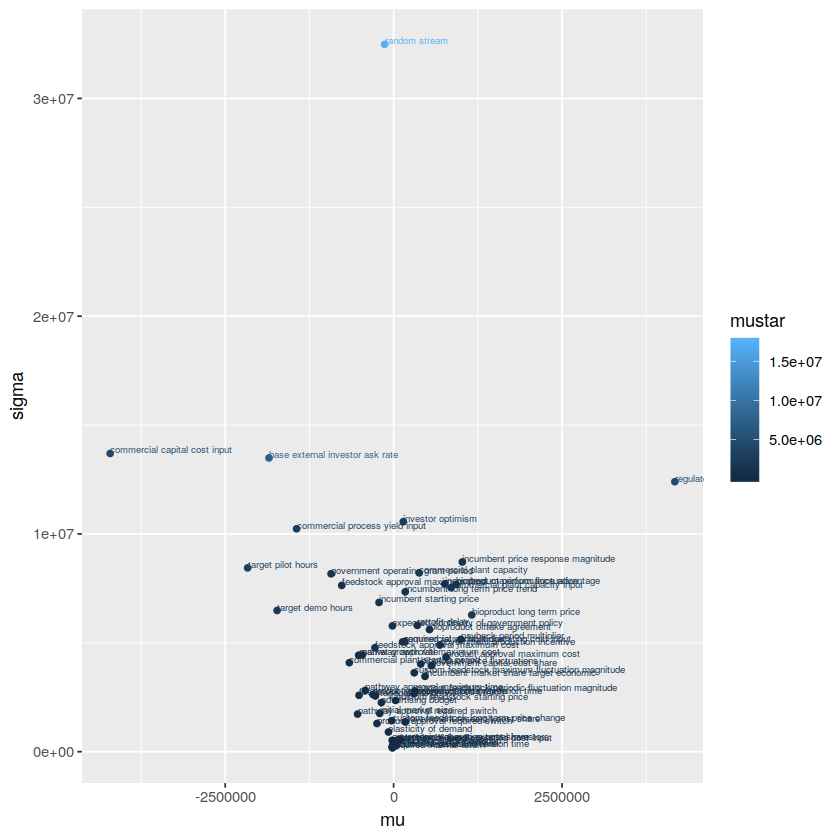

In [90]:
ggplot(z.result, aes(x = mu, y = sigma, color = mustar, label = variable)) +
    geom_point() +
    geom_text(size = 2, hjust = 0, vjust = 0)